In [1]:
import os
import sys
import time
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np

from codebase.utils.log import Log
from codebase.datasets import TextDataset, DataPreprocess
from codebase.utils.prepare import Preparation
from codebase.condGAN import condGAN
%matplotlib inline

In [2]:
# Preparing environment
prep = Preparation()
cfg = prep.set_config('cfg/eval_1_3_new_bird.yml')
cfg.MANUAL_SEED = 40
prep.set_random_seed()
output_dir = prep.set_output_dir()
prep.set_cuda()
prep.show_config()

manual_seed = 40
{'B_VALIDATION': False,
 'CONFIG_NAME': 'Eval1',
 'CUDA': False,
 'DATASET_NAME': 'birds',
 'DATA_DIR': 'data/birds',
 'GAN': {'B_ATTENTION': True,
         'B_DCGAN': False,
         'CONDITION_DIM': 100,
         'DF_DIM': 64,
         'GF_DIM': 32,
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': -1,
 'MANUAL_SEED': 40,
 'RNN_TYPE': 'LSTM',
 'SAVE_DIR': 'results',
 'TEXT': {'CAPTIONS_PER_IMAGE': 10,
          'EMBEDDING_DIM': 256,
          'RNN_LAYERS': 1,
          'WORDS_NUM': 25},
 'TRAIN': {'BATCH_SIZE': 100,
           'B_NET_D': False,
           'DISCRIMINATOR_LR': 0.0002,
           'ENCODER_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_D': [],
           'NET_E': '',
           'NET_E_IMG': '',
           'NET_E_TEXT': 'DAMSMencoders/birds/text_encoder200.pth',
           'NET_G': 'models/birds/attn2_netG_epoch_60.pth',
           'RNN_GRAD_CLIP': 0.25,
           'SMOOTH': {'G

In [3]:
# Init log
log = Log(output_dir)
#log.disallow_print()

# Get data loader
dataprep = DataPreprocess(log)
image_transform = dataprep.image_transform()
dataloader, dataset = dataprep.get_dataloader('test', image_transform, True)

# Define models and go to evaluate
model = condGAN(output_dir, dataloader, dataset.n_words, dataset.ixtoword, log)
start_t = time.time()

Transform: 256
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenames from: data/birds/train/filenames.pickle (8855)
Load filenames from: data/birds/test/filenames.pickle (2933)
Load from:  data/birds/captions.pickle
Dataset test: n_words=5450 emb_num=10
CUDA status: False
GPU ID: -1
Init condGAN ... 


In [4]:
# Make captions
sentences= [
'a bird with a log orange bill, ruffled feathers that is white and gray.',    
'this bird is red with white and has a very short beak',
'the bird has a yellow crown and a black eyering that is round',
'this bird has a green crown black primaries and a white belly',
'this bird has wings that are black and has a white belly',
'this bird has wings that are red and has a yellow belly',
'this bird has wings that are blue and has a red belly',
'this is a small light gray bird with a small head and green crown, nape and some green coloring on its wings',
'his bird is black with white and has a very short beak',
'this small bird has a deep blue crown, back and rump and a bright white belly',
'this is a blue bird with a white throat, breast, belly and abdomen and a small black pointed beak',
'yellow abdomen with a black eye without an eye ring and beak quite short',
'this bird is yellow with black on its head and has a very short beak',
'this bird has wings that are black and has a white belly',
'this bird has a white belly and breast with a short pointy bill',
'this bird is red and white in color with a stubby beak and red eye rings',
'a small red and white bird with a small curved beak',
'this large gray bird has a white throat and a pale russet colored breast.',
'this is a bird with a white breast, grey back and an orange beak.',
'this bird has a red crown with black throat and red belly.'
]

In [5]:
# Make captions
data_dic = {}
captions, cap_lens = model.tokenize_sentences(sentences, dataset.wordtoix)
cap_array, cap_lens, sorted_indices = model.process_captions(captions, cap_lens)
data_dic['generated'] = [cap_array, cap_lens, sorted_indices]

# Generate images from pre-extracted embeddings
images = model.generate_images(data_dic)  # generate images for customized captions
end_t = time.time()
log.add('Total time for evaluation: {}'.format(end_t - start_t))

Load text encoder from: DAMSMencoders/birds/text_encoder200.pth


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Number of nets G/D: 3
Load G from: models/birds/attn2_netG_epoch_60.pth


/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/aleksey/.local/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/aleksey/PycharmProjects/dj-engineer-final/dl-final/codebase/global_attention.py:109: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = self.sm(attn)  # Eq. (2)
/home/aleksey/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.


Total time for evaluation: 54.96190142631531


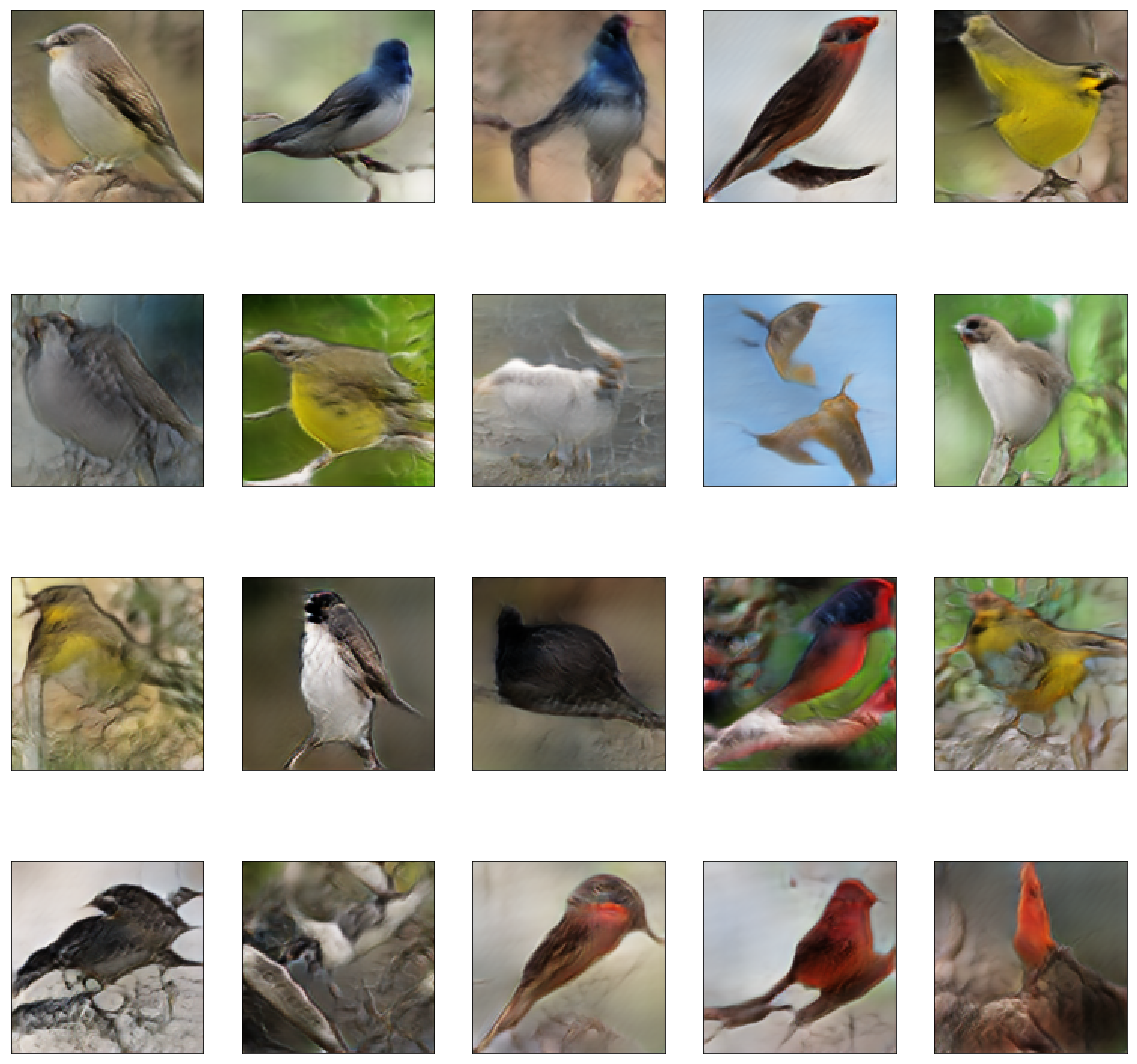

In [6]:
fig = plt.figure(figsize=(20,20))
for i, path in enumerate(images[0][1]):   
    img = Image.open(path)
    ax = fig.add_subplot(4,5, i + 1, xticks=[], yticks=[])
    ax.imshow(np.asarray(img))    